In [1]:
## 기본 library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
## model library
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from keras import models, layers, optimizers
## helper library
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from bayes_opt import BayesianOptimization

import seaborn as sns

data = pd.read_csv('./data/titanic/train.csv')
d = data.copy()
test = pd.read_csv('./data/titanic/test.csv')
submission = pd.read_csv('./data/titanic/gender_submission.csv')

target = data['Survived']
data = data.drop(['PassengerId', 'Survived', 'Name', 'Ticket'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

Using TensorFlow backend.


In [2]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,22.0,1,0,7.2500,NaN,S
1,1,female,38.0,1,0,71.2833,C85,C
2,3,female,26.0,0,0,7.9250,NaN,S
3,1,female,35.0,1,0,53.1000,C123,S
4,3,male,35.0,0,0,8.0500,NaN,S


In [3]:
pd.unique(data['Cabin'])

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [4]:
def cabin_split(a):
    if type(a) == np.float:
        return np.nan
    
    if 'A' in a:
        return 'A'
    elif 'B' in a:
        return 'B'
    elif 'C' in a:
        return 'C'
    elif 'D' in a:
        return 'D'
    elif 'E' in a:
        return 'E'
    elif 'F' in a:
        return 'F'
    else:
        return 'other'

In [5]:
data['Cabin'] = data['Cabin'].map(cabin_split)
test['Cabin'] = test['Cabin'].map(cabin_split)

In [6]:
data['Embarked'] = data['Embarked'].replace(np.nan, -999)
test['Embarked'] = test['Embarked'].replace(np.nan, -999)

In [7]:
d.groupby('Embarked').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Embarked,,,,,,,
C,445.357143,0.553571,1.886905,30.814769,0.386905,0.363095,59.954144
Q,417.896104,0.389610,2.909091,28.089286,0.428571,0.168831,13.276030
S,449.527950,0.336957,2.350932,29.445397,0.571429,0.413043,27.079812


In [8]:
def emb_map(a):
    if a == 'C':
        return 0.738462
    elif a == 'Q':
        return 0.389610
    elif a == 'S':
        return 0.336957
    else:
        return 0

In [9]:
data['Embarked'] = data['Embarked'].map(emb_map)
test['Embarked'] = test['Embarked'].map(emb_map)

In [10]:
d['Cabin'] = d['Cabin'].map(cabin_split)

In [11]:
d.groupby('Cabin').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Cabin,,,,,,,
A,439.600000,0.466667,1.000000,44.833333,0.133333,0.133333,39.623887
B,521.808511,0.744681,1.000000,34.955556,0.361702,0.574468,113.505764
C,406.440678,0.593220,1.000000,36.086667,0.644068,0.474576,100.151341
D,475.939394,0.757576,1.121212,39.032258,0.424242,0.303030,57.244576
E,491.121212,0.757576,1.363636,38.116667,0.333333,0.333333,45.309470
F,390.500000,0.583333,2.333333,19.954545,0.500000,0.500000,18.391667
other,240.800000,0.400000,2.600000,20.800000,0.400000,1.000000,17.965000


In [12]:
lbe = LabelEncoder()

data['Sex'] = lbe.fit_transform(data['Sex'])
test['Sex'] = lbe.fit_transform(test['Sex'])
data['Cabin'] = lbe.fit_transform(data['Cabin'].replace(np.nan, 'nan'))
test['Cabin'] = lbe.fit_transform(test['Cabin'].replace(np.nan, 'nan'))
data['Cabin'] = data['Cabin'].replace(6, 999)
test['Cabin'] = test['Cabin'].replace(6, 999)

In [ ]:
pd.isna(data).sum()

In [14]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=10, random_state=0).fit(data)
new_data = pd.DataFrame(imp.transform(data), columns=data.columns)

imp = IterativeImputer(max_iter=10, random_state=0).fit(test)
new_test = pd.DataFrame(imp.transform(test), columns=test.columns)

In [ ]:
sns.distplot(data['Age'].dropna())

In [ ]:
d = data.copy()
categorical = [
    'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked'
]

In [ ]:
data['Age'] = pd.DataFrame(MinMaxScaler().fit_transform(data['Age'].values.reshape(-1,1)))
data['Fare'] = pd.DataFrame(StandardScaler().fit_transform(data['Fare'].values.reshape(-1,1)))

lbe = LabelEncoder()
data['Sex'] = lbe.fit_transform(data['Sex'])
sex = lbe.classes_
data['Embarked'] = lbe.fit_transform(data['Embarked'])
emb = lbe.classes_

for c in categorical:
    data = pd.concat([data, pd.get_dummies(data[c], prefix=c)], axis=1)
    data = data.drop(c, axis=1)

In [15]:
train_X, test_X, train_y, test_y = train_test_split(new_data, target, test_size=0.3, random_state=0, shuffle=True)

In [16]:
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

In [30]:
## logistic
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    lr = LogisticRegression(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, lr.predict(val_X))/10

print(acc)

0.3190984284532672


c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

In [31]:
## 조금 더 간단히 할 수 있음
lr  = LogisticRegression(random_state=0)
acc = cross_val_score(lr, train_X, train_y, cv=kfold, n_jobs=1, scoring='accuracy')
print(np.mean(acc))

0.7977460711331679


c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

In [32]:
lr = LogisticRegression(random_state=0).fit(train_X, train_y)

c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [33]:
## knn
opt = []
for n in range(2, 30):
    knn = KNeighborsClassifier(n_neighbors=n)
    acc = []
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        knn.fit(tr_X, tr_y)
        acc.append(accuracy_score(val_y, knn.predict(val_X)))
    opt.append(np.mean(acc))

[0.6902088502894955, 0.688564929693962, 0.6837779156327544, 0.7046836228287842, 0.6790219189412738, 0.6886993382961125, 0.6790322580645162, 0.6951095947063689, 0.6966914805624482, 0.6870554177005791, 0.6918631100082714, 0.6982940446650123, 0.7015198511166253, 0.701509511993383, 0.6967121588089331, 0.6966914805624482, 0.6967018196856907, 0.7031327543424318, 0.7015508684863523, 0.7047559966914805, 0.6983250620347394, 0.6903225806451613, 0.6967328370554177, 0.6983147229114971, 0.70154052936311, 0.6935173697270471, 0.6951302729528536, 0.7015301902398676]


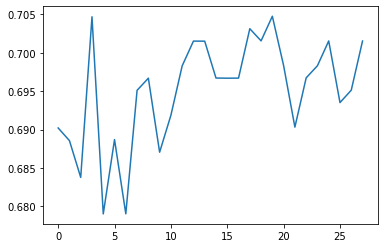

In [34]:
plt.plot(opt)
print(opt)


In [37]:
## knn's n_neighbor = 3
knn = KNeighborsClassifier(n_neighbors=4).fit(train_X, train_y)

In [38]:
## RF with no paramter tuning
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    rf = RandomForestClassifier(random_state=0).fit(tr_X, tr_y)
    acc += accuracy_score(val_y, rf.predict(val_X))/k

print(acc)

0.797777088502895


In [39]:
rf = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [20]:
## xgboost
xgb_bounds = {
    'max_depth': (3, 12),
    'subsample': (0.3, 1),
    'colsample_bytree': (0.3, 1),
    'reg_alpha': (0.1, 3),
    'reg_lamda': (0.1, 3)
}

best_ns = []

def bayes_xgb(max_depth, subsample, colsample_bytree, reg_alpha, reg_lamda):
    global best_ns
    params = {
        'n_estimators': 1000,
        'booster': 'gbtree',
        'tree_method': 'hist',
        'random_state': 0,
        'n_jobs': -1,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'reg_alpha': reg_alpha,
        'reg_lamda': reg_lamda
    }
    
    acc = 0
    best_n = 0
    for tr_idx, val_idx in kfold.split(train_X):
        tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
        val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
        clf = XGBClassifier(**params).fit(tr_X, tr_y, eval_metric = 'error', eval_set=[[val_X, val_y]], early_stopping_rounds=100, verbose=0)
        acc += accuracy_score(val_y, clf.predict(val_X))/k
        best_n += clf.best_iteration/k
    best_ns.append(best_n)
    return acc


In [21]:
k = 4
kfold = KFold(n_splits=k, shuffle=True, random_state=0)

In [22]:
%%time
optimizer = BayesianOptimization(bayes_xgb, xgb_bounds, random_state=0)

init_points = 10
n_iter = 20

optimizer.maximize(init_points=init_points, n_iter=n_iter)

|   iter    |  target   | colsam... | max_depth | reg_alpha | reg_lamda | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8283   |  0.6842   |  9.437    |  1.848    |  1.68     |  0.5966   |
|  2        |  0.8315   |  0.7521   |  6.938    |  2.686    |  2.895    |  0.5684   |
|  3        |  0.8267   |  0.8542   |  7.76     |  1.747    |  2.784    |  0.3497   |
|  4        |  0.8091   |  0.361    |  3.182    |  2.515    |  2.357    |  0.909    |
|  5        |  0.8347   |  0.985    |  10.19    |  1.438    |  2.364    |  0.3828   |
|  6        |  0.8219   |  0.7479   |  4.29     |  2.84     |  1.613    |  0.5903   |
|  7        |  0.8219   |  0.4852   |  9.968    |  1.423    |  1.748    |  0.3132   |
|  8        |  0.8315   |  0.7323   |  8.509    |  1.889    |  2.837    |  0.7773   |
|  9        |  0.8251   |  0.5517   |  6.933    |  2.123    |  0.2747   |  0.7667   |
|  10       |  0.8347   |  0.7694   |  4.893    |  0.4

In [ ]:
import pickle
with open('best_params.bin', 'rb') as f:
    best_params = pickle.load(f)

In [23]:
optimizer.max['params']

{'colsample_bytree': 0.7694465087327116,
 'max_depth': 4.893443049664568,
 'reg_alpha': 0.47388626319907456,
 'reg_lamda': 1.0147422176801333,
 'subsample': 0.5545975396598358}

In [24]:
best_ns

[26.0,
 69.75,
 33.75,
 66.0,
 121.5,
 29.5,
 70.75,
 9.0,
 48.0,
 42.75,
 59.0,
 26.5,
 97.25,
 16.0,
 41.25,
 11.0,
 29.0,
 13.0,
 22.75,
 54.75,
 18.75,
 38.25,
 11.25,
 69.25,
 17.5,
 47.25,
 18.25,
 50.0,
 60.0,
 25.25]

In [25]:
best_params = {
    'n_estimators': 40,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'random_state': 0,
    'n_jobs': -1,
    'max_depth': int(optimizer.max['params']['max_depth']),
    'subsample': optimizer.max['params']['subsample'],
    'colsample_bytree': optimizer.max['params']['colsample_bytree'],
    'reg_alpha': optimizer.max['params']['reg_alpha'],
    'reg_lamda': optimizer.max['params']['reg_lamda'],
    'metric': 'error'
}

clf = XGBClassifier(**best_params).fit(train_X, train_y)


In [47]:
## voting
from sklearn.ensemble import VotingClassifier

v_lr = LogisticRegression(random_state=0)
v_knn = KNeighborsClassifier(n_neighbors=3)
v_rf = RandomForestClassifier(max_depth=9, random_state=0)

vclf = VotingClassifier(estimators=[
    ('lr', v_lr),
    ('knn', v_knn),
    ('rf', v_rf)
], voting='soft')

acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    vclf.fit(tr_X, tr_y)
    acc += accuracy_score(val_y, vclf.predict(val_X))/10

print(acc)

c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\young\anaconda3\envs\study\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

0.3152688172043011


개별 모델들과 앙상블모형을 통틀어 xgboost가 가장 높은 성능을 보여줄 것으로 기대된다.  
실제 test셋의 결과는 어떨까?


In [48]:
print('lr:', accuracy_score(test_y, lr.predict(test_X)))
print('knn:', accuracy_score(test_y, knn.predict(test_X)))
print('rf:', accuracy_score(test_y, rf.predict(test_X)))
print('xgboost:', accuracy_score(test_y, clf.predict(test_X)))
print('voting:', accuracy_score(test_y, vclf.predict(test_X)))

lr: 0.8059701492537313
knn: 0.6977611940298507
rf: 0.8134328358208955
xgboost: 0.8283582089552238
voting: 0.8022388059701493


In [ ]:
## nn 및 stacking

In [ ]:
## nn
input_layer = layers.Input(shape=((train_X.shape[1], )))

layer1 = layers.Dense(64, activation='relu')(input_layer)
# drop1 = layers.Dropout(0.1)(layer1)
layer2 = layers.Dense(32, activation='relu')(layer1)

out_layer = layers.Dense(1, activation='sigmoid')(layer2)

model = models.Model(input_layer, out_layer)

In [ ]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])

In [ ]:
cp = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)

In [ ]:
model.fit(train_X, train_y,
          epochs=200,
          validation_split=0.3,
          callbacks=[es]
         )

In [ ]:
model.evaluate(test_X, test_y)

In [ ]:
## self cv 예시
from keras.wrappers.scikit_learn import KerasClassifier

def make_model():
    K.clear_session()
    input_layer = layers.Input(shape=((train_X.shape[1], )))

    layer1 = layers.Dense(32, activation='relu')(input_layer)
    drop1 = layers.Dropout(0.1)(layer1)
    layer2 = layers.Dense(16, activation='relu')(drop1)
    
    out_layer = layers.Dense(1, activation='sigmoid')(layer2)

    model = models.Model(input_layer, out_layer)
    
    model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['acc'])
    
    return model

In [ ]:
acc = 0
for tr_idx, val_idx in kfold.split(train_X):
    tr_X, tr_y = train_X.iloc[tr_idx, :], train_y.iloc[tr_idx]
    val_X, val_y = train_X.iloc[val_idx, :], train_y.iloc[val_idx]
    model = make_model()
    model.fit(tr_X, tr_y, 
            epochs=40, 
#           callbacks = [es], 
            validation_data=[val_X, val_y],
            verbose=0)
    acc += model.evaluate(val_X, val_y)[1]/10

print(acc)


In [ ]:
acc

In [ ]:
model.evaluate(test_X, test_y)

In [ ]:
## stacking

In [ ]:
## meta_training
meta_train = pd.DataFrame()
meta_train['lr'] = list(zip(*lr.predict_proba(train_X)))[0]
meta_train['knn'] = list(zip(*knn.predict_proba(train_X)))[0]
meta_train['rf'] = list(zip(*rf.predict_proba(train_X)))[0]
meta_train['xgboost'] = list(zip(*clf.predict_proba(train_X)))[0]
meta_train['voting'] = list(zip(*vclf.predict_proba(train_X)))[0]

## meta_test
meta_test = pd.DataFrame()
meta_test['lr'] = list(zip(*lr.predict_proba(test_X)))[0]
meta_test['knn'] = list(zip(*knn.predict_proba(test_X)))[0]
meta_test['rf'] = list(zip(*rf.predict_proba(test_X)))[0]
meta_test['xgboost'] = list(zip(*clf.predict_proba(test_X)))[0]
meta_test['voting'] = list(zip(*vclf.predict_proba(test_X)))[0]
# knn
# rf
# clf
# vclf

In [ ]:
meta_train

In [ ]:
from keras import optimizers
def stack_net():
    K.clear_session()
    
    input_layer = layers.Input(shape=((meta_train.shape[1], )))

    layer1 = layers.Dense(4, activation='relu')(input_layer)
#     layer2 = layers.Dense(8, activation='relu')(layer1)
    
    out_layer = layers.Dense(1, activation='sigmoid')(layer1)

    model = models.Model(input_layer, out_layer)
    
    model.compile(optimizer=optimizers.Adam(lr=0.001),
             loss='binary_crossentropy',
             metrics=['acc'])
    
    return model

In [ ]:
es = EarlyStopping(monitor='val_acc', patience=20, restore_best_weights=True, verbose=1)
stack = stack_net()
stack.fit(meta_train, train_y,
          epochs=200,
          validation_split = 0.3,
          callbacks = [es]
         )

In [ ]:
stack.evaluate(meta_test, test_y)

In [ ]:
print('lr:', accuracy_score(test_y, lr.predict(test_X)))
print('knn:', accuracy_score(test_y, knn.predict(test_X)))
print('rf:', accuracy_score(test_y, rf.predict(test_X)))
print('xgboost:', accuracy_score(test_y, clf.predict(test_X)))
print('voting:', accuracy_score(test_y, vclf.predict(test_X)))
print('nn:', model.evaluate(test_X, test_y)[1])
print('stacking:', stack.evaluate(meta_test, test_y)[1])

In [27]:
clf.predict(test)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

In [53]:
submission['Survived'] = clf.predict(new_test)

In [54]:
submission.to_csv('sub5.csv', index=False)

In [41]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,3,1,34.5,0,0,7.8292,999,0.389610
1,3,0,47.0,1,0,7.0000,999,0.336957
2,2,1,62.0,0,0,9.6875,999,0.389610
3,3,1,27.0,0,0,8.6625,999,0.336957
4,3,0,22.0,1,1,12.2875,999,0.336957
...,...,...,...,...,...,...,...,...
413,3,1,NaN,0,0,8.0500,999,0.336957
414,1,0,39.0,0,0,108.9000,2,0.738462
415,3,1,38.5,0,0,7.2500,999,0.336957
416,3,1,NaN,0,0,8.0500,999,0.336957
